In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization, Input, Reshape, Conv3DTranspose, UpSampling3D, LSTM
from tensorflow.keras.optimizers import Adamax
from skimage.util import random_noise
from skimage.metrics import structural_similarity, mean_squared_error
from scipy.ndimage import rotate
from skimage.transform import resize
import nibabel as nib
from ipywidgets import interact, IntSlider, RadioButtons
import time
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
try:
  for image in data:#[:10]:
    #print(data_root+image)
    im=nib.load(data_root+image).get_fdata()
    im=resize(im, shape_required, preserve_range=True)
    im_min = np.min(im)
    im_max = np.max(im)
    #print(im_min,im_max)
    im=((im - im_min)*255) / (im_max - im_min)
    im=np.expand_dims(im, axis=3)
    images_original.append(im)

    keyword = image[:-7]
    print(keyword)
    for labell in label:
      if keyword in labell:
        #print(labell)
        im=nib.load(label_root+labell).get_fdata()
    im=resize(im, shape_required, preserve_range=True)
    im_min = np.min(im)
    im_max = np.max(im)
    im=(im - im_min) / (im_max - im_min)
    im = np.where(im > 0, 1, 0)
    im=np.expand_dims(im, axis=3)
    labels_original.append(im)
except AttributeError:
  pass

In [ ]:
def label_img(img):
  return [0]

def rotateit(image, theta, isseg=False):
  order = 0 if isseg == True else 5
  return ndimage.rotate(image, float(theta), reshape=False, order=order, mode='nearest')

def data_nii_to_npy_2():
  dataset_array = []
  dataset_labels = []
  count = 0

  img_path = "/content/drive/My Drive/FYP_1/"
  saveimg_path = "/content/drive/My Drive/"

  img_names = os.listdir(img_path)
  shuffle(img_names)
  for img_name in img_names:
     # print(img_name)
      img_new = nib.load(img_path + img_name)#load
      #img = np.array(img)
      imag_data_nparray = img_new.get_fdata()
      label_current_image=label_img(img_name)
      imag_data_nparray=resize(imag_data_nparray,(64,64,64))
      image_data_nparray_rotate=rotateit(imag_data_nparray,180)
      #print(label_current_image)
      dataset_array.append(imag_data_nparray)
      dataset_array.append(image_data_nparray_rotate)
      dataset_labels.append(label_current_image)
      dataset_labels.append(label_current_image)

  dataset_array = np.array(dataset_array)
  dataset_labels = np.array(dataset_labels)
  return dataset_array, dataset_labels

In [ ]:
data , labels = data_nii_to_npy_2()

In [ ]:
np.save("data.npy", data)
np.save("labels.npy", labels)

In [ ]:
train_dataset_array = np.load("data.npy")
train_dataset_array_labels = np.load("labels.npy",allow_pickle=True)

print(train_dataset_array.shape)
print(train_dataset_array_labels.shape)

(454, 64, 64, 64)
(454, 1)


In [ ]:
# partition the data into training and testing splits using 70% of
# the data for training and the remaining 30% for testing
(trainX, testX, trainY, testY) = train_test_split(train_dataset_array, train_dataset_array_labels, test_size=0.30, stratify=train_dataset_array_labels)

In [ ]:
#Normalize Images
X_train = trainX.astype('float32') / 255.0
X_test = testX.astype('float32') / 255.0

In [ ]:
#Image Dimension
IMAGE_DIM=(64,64,64,1)

#Required Feature vector size after encoding
ENCODED_SIZE=512

def ConvAutoEncoder(img_dim, encoded_size):
    #Encoder Part
    enc = keras.models.Sequential()
    enc.add(InputLayer(img_dim))
    enc.add(Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    enc.add(MaxPooling3D(pool_size=(2, 2, 2)))
    enc.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    enc.add(MaxPooling3D(pool_size=(2, 2, 2)))
    enc.add(Flatten())
    enc.add(Dense(encoded_size))

    #Decoder Part
    dec = keras.models.Sequential()
    dec.add(InputLayer((encoded_size,)))
    dec.add(Dense(262144))
    dec.add(Reshape((16, 16, 16, 64)))
    dec.add(UpSampling3D(size=(2,2,2)))
    dec.add(Conv3DTranspose(filters=64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    dec.add(UpSampling3D(size=(2,2,2)))
    dec.add(Conv3DTranspose(filters=32, kernel_size=(3, 3, 3), activation=None, padding='same'))

    return enc, dec

encoder, decoder = ConvAutoEncoder(img_dim=IMAGE_DIM, encoded_size=ENCODED_SIZE)

#Print Summary
encoder.summary()
#plot_model(encoder, show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 64, 64, 64, 32)    896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 32, 32, 32, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 32, 32, 32, 64)    55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 16, 16, 16, 64)    0         
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               134218240 
Total params: 134,274,496
Trainable params: 134,274,496
Non-trainable params: 0
__________________________________________

In [ ]:
decoder.summary()
#plot_model(decoder, show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 262144)            134479872 
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 16, 64)    0         
_________________________________________________________________
up_sampling3d (UpSampling3D) (None, 32, 32, 32, 64)    0         
_________________________________________________________________
conv3d_transpose (Conv3DTran (None, 32, 32, 32, 64)    110656    
_________________________________________________________________
up_sampling3d_1 (UpSampling3 (None, 64, 64, 64, 64)    0         
_________________________________________________________________
conv3d_transpose_1 (Conv3DTr (None, 64, 64, 64, 32)    55328     
Total params: 134,645,856
Trainable params: 134,645,856
Non-trainable params: 0
________________________________________

In [ ]:
input = Input(IMAGE_DIM)
encoded = encoder(input)
decoded = decoder(encoded)

cae = keras.models.Model(inputs=input, outputs=decoded)
cae.compile(optimizer='adamax', loss='mean_squared_error')

In [ ]:
#size is reduced to less due to GPU limit
X_train = X_train.reshape(X_train.shape[0],64,64,64,1)
X_test = X_test.reshape(X_test.shape[0],64,64,64,1)

In [ ]:
cae.fit(X_train, X_train, batch_size=1, epochs=5, verbose=1, validation_data=(X_test, X_test))

Epoch 1/5
317/317 [==============================] - 53s 141ms/step - loss: 8.1869 - val_loss: 1.3084
Epoch 2/5
317/317 [==============================] - 45s 143ms/step - loss: 1.3516 - val_loss: 1.2176
Epoch 3/5
317/317 [==============================] - 46s 146ms/step - loss: 1.3735 - val_loss: 1.0977
Epoch 4/5
317/317 [==============================] - 46s 145ms/step - loss: 0.9634 - val_loss: 0.9524
Epoch 5/5
317/317 [==============================] - 46s 145ms/step - loss: 1.0300 - val_loss: 0.8627


Training Loss:  1.008810043334961
Validation Loss:  0.8626970052719116


Text(0.5, 1.0, 'Training and validation loss')

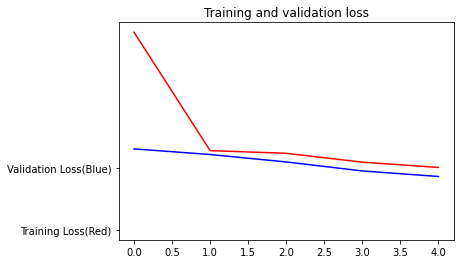

In [ ]:
loss=cae.history.history['loss']
val_loss=cae.history.history['val_loss']

print("Training Loss: ",loss[-1])
print("Validation Loss: ",val_loss[-1])
epochs=range(len(loss)) # Get number of epochs

plt.figure()
plt.plot(epochs, loss, 'r', "Training Loss(Red)")
plt.plot(epochs, val_loss, 'b', "Validation Loss(Blue)")
plt.title('Training and validation loss')

In [ ]:
#Save model for later use
cae.save('LeNetCoder.h5')

In [ ]:
# Load the trained Model
#from keras.models import load_model
cae = load_model('LeNetCoder.h5')

In [ ]:
# Extract 'Encoder' Part from it
encoder = cae.layers[1]

images = X_train
codes = encoder.predict(images)

In [ ]:
from sklearn.neighbors import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [ ]:
def get_similar(image, n_neighbors=5):

    code = encoder.predict(image[None])

    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)

    return distances,images[idx]

def show_similar(image):
    start_time = time.time()
    distances,neighbors = get_similar(image,n_neighbors=5)

    print("                                     \033[1m"+"QUERY IMAGE"+"\033[0m")
    #Show given image
    ImageSliceViewer3D(image.reshape(64,64,64))

    print("                                    \033[1m"+"RETRIEVED IMAGES"+"\033[0m")
    for i in range(4):
        ImageSliceViewer3D(neighbors[i+1].reshape(64,64,64))
        print("Dist={:.3f}".format(distances[i+1]))
    plt.show()
    end_time = time.time()
    exec_time = end_time-start_time
    print("Execution Time (in seconds):",exec_time)

class ImageSliceViewer3D:
    def __init__(self, volume, figsize=(3,3), cmap='gray'):
        self.volume = volume
        self.figsize = figsize
        self.cmap = cmap
        self.v = [np.min(volume), np.max(volume)]

        # Call to select slice plane
        interact(self.view_selection, view=RadioButtons(
            options=['x-y','y-z', 'z-x'], value='x-y',
            description='Slice plane selection:', disabled=False,
            style={'description_width': 'initial'}))

    def view_selection(self, view):
        # Transpose the volume to orient according to the slice plane selection
        orient = {"y-z":[1,2,0], "z-x":[2,0,1], "x-y": [0,1,2]}
        self.vol = np.transpose(self.volume, orient[view])
        maxZ = self.vol.shape[2] - 1

        # Call to view a slice within the selected slice plane
        interact(self.plot_slice,
            z=IntSlider(min=0, max=maxZ, step=1, continuous_update=False,
            description='Image Slice:'))

    def plot_slice(self, z):
        # Plot slice for the given plane and slice
        self.fig = plt.figure(figsize=self.figsize)
        plt.imshow(self.vol[:,:,z], cmap=plt.get_cmap(self.cmap),
            vmin=self.v[0], vmax=self.v[1])

In [ ]:
show_similar(X_test[31])

                                     QUERY IMAGE


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

                                    RETRIEVED IMAGES


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

Dist=6.116


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

Dist=6.692


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

Dist=6.792


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

Dist=6.838
Execution Time (in seconds): 0.9948885440826416


In [ ]:
def show_similar2d(image):
    start_time = time.time()
    distances,neighbors = get_similar(image,n_neighbors=5)

    print("                                     \033[1m"+"QUERY IMAGE"+"\033[0m")
    #Show given image
    plt.imshow(image[:,:,5].reshape(64,64),cmap='gray')
    plt.title("Slice 5")
    plt.show()

    print("                                    \033[1m"+"RETRIEVED IMAGES"+"\033[0m")
    plt.figure(figsize=(20, 20))
    for i in range(4):
        ax = plt.subplot(1, 5, i+1)
        plt.imshow(neighbors[i+1][:,:,5].reshape(64,64),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title("Dist={:.3f} (Slice 5)".format(distances[i+1]))
    plt.show()
    end_time = time.time()
    exec_time = end_time-start_time
    print("Execution Time (in seconds):",exec_time)


                                     QUERY IMAGE


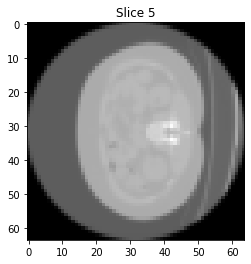

                                    RETRIEVED IMAGES


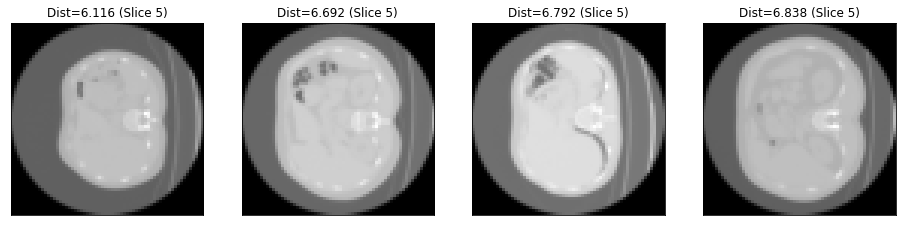

Execution Time (in seconds): 0.5089616775512695


In [ ]:
show_similar2d(X_test[31])